# Tutorial 8: Advanced Cost Functions

**Learning Objectives:**
- Understand built-in cost metrics (SSE, RMSE, GaussianNLL)
- Implement custom cost functions
- Apply weighted fitting for heteroscedastic data
- Use regularisation to prevent over-fitting
- Combine multiple objectives

**Prerequisites:** Tutorials 1-2, basic statistics

**Runtime:** ~15 minutes

## Introduction

The **cost function** (or loss function) quantifies how well model predictions match observations. Chronopt provides built-in metrics, but real-world problems often require:

- **Weighted fitting** when measurement errors vary
- **Custom metrics** for domain-specific requirements
- **Regularisation** to prevent over-fitting
- **Multi-objective** combinations

This tutorial demonstrates advanced cost function techniques.

In [1]:
# Import plotting utilities
from functools import partial

import chronopt as chron
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

## Built-in Cost Metrics

Chronopt provides three standard metrics:

### 1. Sum of Squared Errors (SSE)

$$
\text{SSE} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

- Default metric
- Penalises large errors heavily
- Assumes constant variance

### 2. Root Mean Squared Error (RMSE)

$$
\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$
- Normalised by sample size
- Same units as data
- Better for comparing across datasets

### 3. Gaussian Negative Log-Likelihood (GaussianNLL)

$$
\text{NLL} = \frac{n}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
- Statistically principled
- Enables Bayesian inference
- Can estimate noise parameter $\sigma$

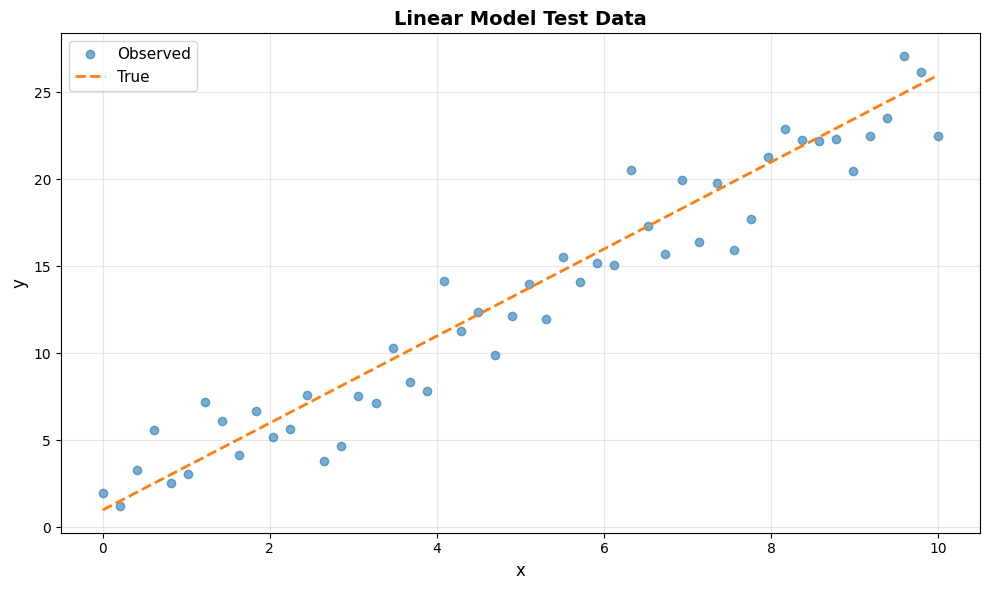

In [2]:
# Generate simple test data
x_data = np.linspace(0, 10, 50)
y_true = 2.5 * x_data + 1.0
y_observed = y_true + np.random.normal(0, 2.0, len(x_data))

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_observed, "o", label="Observed", alpha=0.6, markersize=6)
plt.plot(x_data, y_true, "--", label="True", linewidth=2)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title("Linear Model Test Data", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
# Compare built-in metrics
def linear_model(params):
    """Simple linear model: y = slope * x + intercept"""
    slope, intercept = params
    return slope * x_data + intercept


# Define problem
builder = (
    chron.VectorBuilder()
    .with_objective(linear_model)
    .with_data(y_observed)
    .with_parameter("slope", 1.0)
    .with_parameter("intercept", 0.0)
)

# Test each metric
metrics = {"SSE": chron.SSE(), "RMSE": chron.RMSE(), "GaussianNLL": chron.GaussianNLL()}

results = {}
for name, metric in metrics.items():
    result = builder.with_cost(metric).build().optimise()
    results[name] = result

# Display comparison
print("\n" + "=" * 70)
print("COST METRIC COMPARISON")
print("=" * 70)
print("True parameters:    [2.5, 1.0]")
print("-" * 70)
print(f"{'Metric':<15} {'Slope':<12} {'Intercept':<12} {'Cost Value'}")
print("-" * 70)

for name, result in results.items():
    print(f"{name:<15} {result.x[0]:<12.4f} {result.x[1]:<12.4f} {result.value:<12.3e}")

print("\n💡 Note: All metrics produce similar parameter estimates!")
print("   The cost values differ in scale, but optima are equivalent.")


COST METRIC COMPARISON
True parameters:    [2.5, 1.0]
----------------------------------------------------------------------
Metric          Slope        Intercept    Cost Value
----------------------------------------------------------------------
SSE             2.3840       1.1288       1.650e+02   
RMSE            2.3840       1.1288       1.668e+02   
GaussianNLL     2.3840       1.1288       2.953e+02   

💡 Note: All metrics produce similar parameter estimates!
   The cost values differ in scale, but optima are equivalent.


## Weighted Fitting: Heteroscedastic Data

Real data often has **non-uniform measurement errors** (heteroscedasticity). Points with larger errors should contribute less to the cost function.

### Weighted Least Squares
$$\text{WSSE} = \sum_{i=1}^{n} w_i (y_i - \hat{y}_i)^2$$

where $w_i = 1/\sigma_i^2$ (inverse variance weighting).

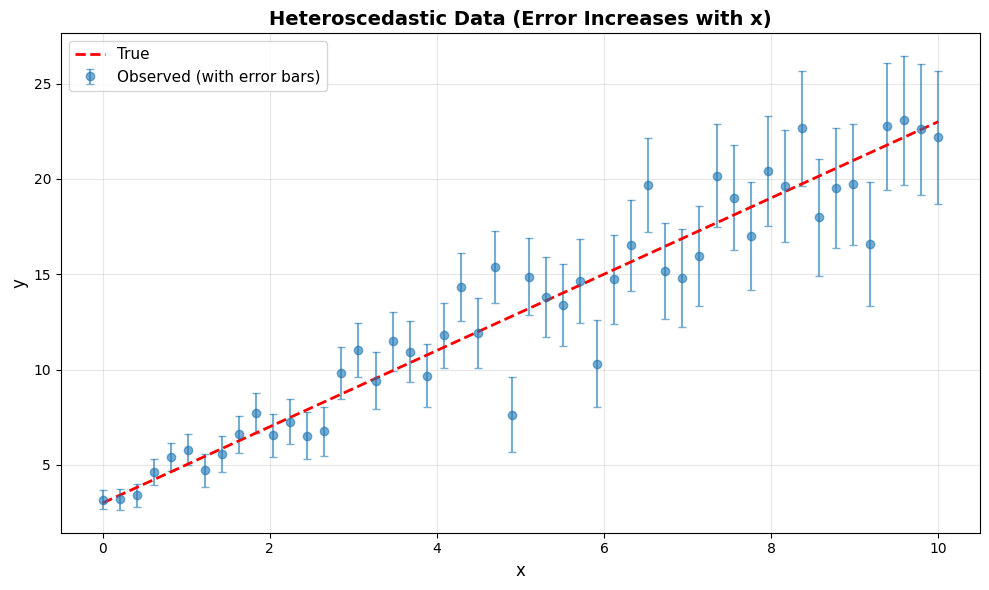

Error range: [0.50, 3.50]
Notice: Uncertainty increases from left to right!


In [4]:
# Generate heteroscedastic data (error increases with x)
x_hetero = np.linspace(0, 10, 50)
y_true_hetero = 2.0 * x_hetero + 3.0

# Error increases linearly with x
error_std = 0.5 + 0.3 * x_hetero
y_hetero = y_true_hetero + np.random.normal(0, error_std)

# Visualize heteroscedastic data
fig, ax = plt.subplots(figsize=(10, 6))

# Error bars showing measurement uncertainty
ax.errorbar(
    x_hetero,
    y_hetero,
    yerr=error_std,
    fmt="o",
    alpha=0.6,
    label="Observed (with error bars)",
    capsize=3,
    markersize=6,
)
ax.plot(x_hetero, y_true_hetero, "r--", linewidth=2, label="True")

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title(
    "Heteroscedastic Data (Error Increases with x)", fontsize=14, fontweight="bold"
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Error range: [{error_std.min():.2f}, {error_std.max():.2f}]")
print("Notice: Uncertainty increases from left to right!")

In [5]:
# Custom weighted SSE cost function
class WeightedSSE:
    """Weighted sum of squared errors."""

    def __init__(self, weights):
        """
        Parameters
        ----------
        weights : array_like
            Weight for each data point (typically 1/sigma^2)
        """
        self.weights = np.asarray(weights)

    def __call__(self, predicted, observed):
        """Compute weighted SSE."""
        residuals = observed - predicted
        return np.sum(self.weights * residuals**2)


# Weights: inverse variance (1/sigma^2)
weights = 1.0 / error_std**2


def linear_model_hetero(params):
    slope, intercept = params
    return slope * x_hetero + intercept


# Construct custom cost
weighted_sse = WeightedSSE(weights)

# Fit WITHOUT weights (standard SSE)
result_unweighted = (
    chron.VectorBuilder()
    .with_objective(linear_model_hetero)
    .with_data(y_hetero)
    .with_parameter("slope", 1.0)
    .with_parameter("intercept", 0.0)
    .with_cost(chron.SSE())  # Standard SSE
    .build()
    .optimise()
)

# Fit with weights
result_weighted = (
    chron.ScalarBuilder()
    .with_objective(lambda x: weighted_sse(linear_model_hetero(x), y_hetero))
    .with_parameter("slope", 1.0)
    .with_parameter("intercept", 0.0)
    .build()
    .optimise()
)

print("\n" + "=" * 70)
print("WEIGHTED vs UNWEIGHTED FITTING")
print("=" * 70)
print("True parameters:        [2.0, 3.0]")
print(f"Unweighted fit:         {result_unweighted.x}")
print(f"Weighted fit:           {result_weighted.x}")
print("-" * 70)
print(f"Unweighted error:       {np.linalg.norm(result_unweighted.x - [2.0, 3.0]):.4f}")
print(f"Weighted error:         {np.linalg.norm(result_weighted.x - [2.0, 3.0]):.4f}")
print("\n💡 Weighted fit is more accurate!")
print("   It down-weights noisy (high-x) points appropriately.")


WEIGHTED vs UNWEIGHTED FITTING
True parameters:        [2.0, 3.0]
Unweighted fit:         [1.93530391 3.27981493]
Weighted fit:           [1.97635486 3.10714606]
----------------------------------------------------------------------
Unweighted error:       0.2872
Weighted error:         0.1097

💡 Weighted fit is more accurate!
   It down-weights noisy (high-x) points appropriately.


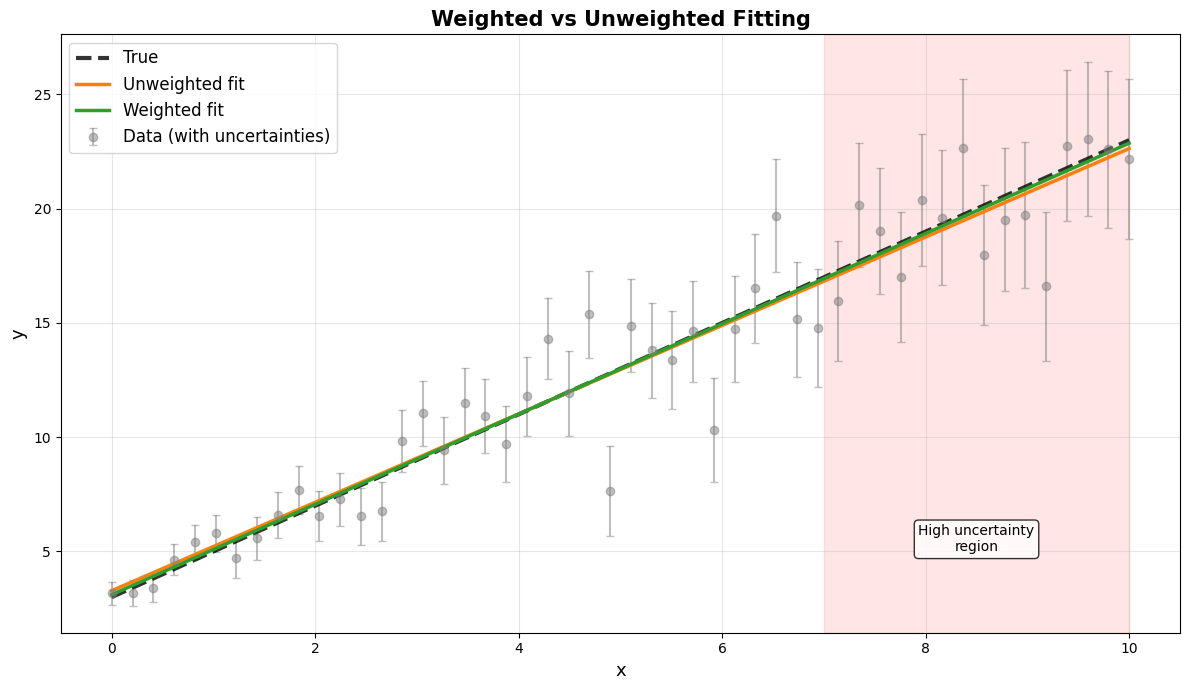

In [6]:
# Visualize comparison
x_plot = np.linspace(0, 10, 200)
y_true_plot = 2.0 * x_plot + 3.0
y_unweighted = result_unweighted.x[0] * x_plot + result_unweighted.x[1]
y_weighted = result_weighted.x[0] * x_plot + result_weighted.x[1]

fig, ax = plt.subplots(figsize=(12, 7))

# Data with error bars
ax.errorbar(
    x_hetero,
    y_hetero,
    yerr=error_std,
    fmt="o",
    alpha=0.5,
    label="Data (with uncertainties)",
    capsize=3,
    markersize=6,
    color="gray",
)

# Fits
ax.plot(x_plot, y_true_plot, "k--", linewidth=3, label="True", alpha=0.8)
ax.plot(x_plot, y_unweighted, linewidth=2.5, label="Unweighted fit", color="#ff7f0e")
ax.plot(x_plot, y_weighted, linewidth=2.5, label="Weighted fit", color="#2ca02c")

ax.set_xlabel("x", fontsize=13)
ax.set_ylabel("y", fontsize=13)
ax.set_title("Weighted vs Unweighted Fitting", fontsize=15, fontweight="bold")
ax.legend(fontsize=12, loc="upper left")
ax.grid(True, alpha=0.3)

# Highlight the difference in high-error region
ax.axvspan(7, 10, alpha=0.1, color="red", label="High uncertainty region")
ax.text(
    8.5,
    5,
    "High uncertainty\nregion",
    ha="center",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

## Regularisation: Preventing Over-fitting

When fitting complex models with many parameters, **regularisation** prevents over-fitting by penalising large parameter values.

### L2 Regularisation (Ridge)
$$\text{Cost} = \text{Data Term} + \lambda \sum_{i=1}^{p} \theta_i^2$$

### L1 Regularisation (Lasso)  
$$\text{Cost} = \text{Data Term} + \lambda \sum_{i=1}^{p} |\theta_i|$$

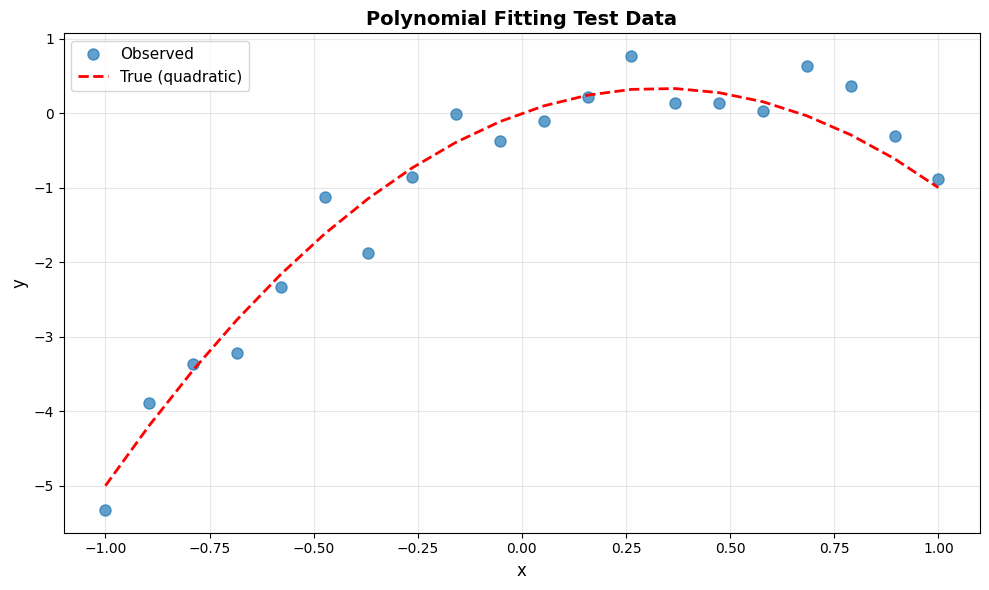

In [7]:
# Generate data for polynomial fitting
np.random.seed(123)
x_poly = np.linspace(-1, 1, 20)
y_true_poly = 2 * x_poly - 3 * x_poly**2  # True: quadratic
y_poly = y_true_poly + np.random.normal(0, 0.3, len(x_poly))

plt.figure(figsize=(10, 6))
plt.plot(x_poly, y_poly, "o", label="Observed", alpha=0.7, markersize=8)
plt.plot(x_poly, y_true_poly, "r--", linewidth=2, label="True (quadratic)")
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.title("Polynomial Fitting Test Data", fontsize=14, fontweight="bold")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Fit high-degree polynomial (degree 8) - prone to over-fitting
degree = 8


def polynomial_model(params):
    """Polynomial model: sum of coefficients * x^i"""
    y_pred = np.zeros_like(x_poly)
    for i, coef in enumerate(params):
        y_pred += coef * x_poly**i
    return y_pred


# Custom cost with L2 regularisation
class RegularisedSSE:
    """SSE with L2 regularisation (Ridge)."""

    def __init__(self, lambda_reg=0.0):
        self.lambda_reg = lambda_reg

    def __call__(self, predicted, observed, params=None):
        # Data term
        sse = np.sum((observed - predicted) ** 2)

        # Regularisation term (note: params must be passed separately)
        if params is not None and self.lambda_reg > 0:
            reg_term = self.lambda_reg * np.sum(params**2)
            return sse + reg_term

        return sse


# Note: Chronopt's built-in costs don't support parameter access yet,
# so we'll compare by manually adding regularisation to parameter update

# Unregularised fit
initial_params = np.zeros(degree + 1)
initial_params[0] = np.mean(y_poly)

builder_poly = chron.VectorBuilder().with_objective(polynomial_model).with_data(y_poly)

for i in range(degree + 1):
    builder_poly = builder_poly.with_parameter(f"c{i}", initial_params[i])

result_unreg = (
    builder_poly.with_cost(chron.SSE())
    .with_optimiser(chron.NelderMead().with_max_iter(2000))
    .build()
    .optimise()
)

print("\n" + "=" * 70)
print("POLYNOMIAL FITTING (Degree 8)")
print("=" * 70)
print("Unregularised coefficients:")
print(f"  {result_unreg.x}")
print(f"  Max |coef|: {np.max(np.abs(result_unreg.x)):.2f}")
print(f"  SSE: {result_unreg.value:.4f}")


POLYNOMIAL FITTING (Degree 8)
Unregularised coefficients:
  [ 1.76916563e-03  1.96793262e+00 -4.26606389e+00  1.70512990e+00
  3.98781374e+00 -2.59931773e+00 -3.98125430e-01  1.08590028e+00
 -2.43719499e+00]
  Max |coef|: 4.27
  SSE: 1.8069


### Visualise Overfitting

To visualise model overfitting, an extrapolation region is plotted.
This provides insight into whether the model accurately captures the system dynamics and not the underlying noise model.

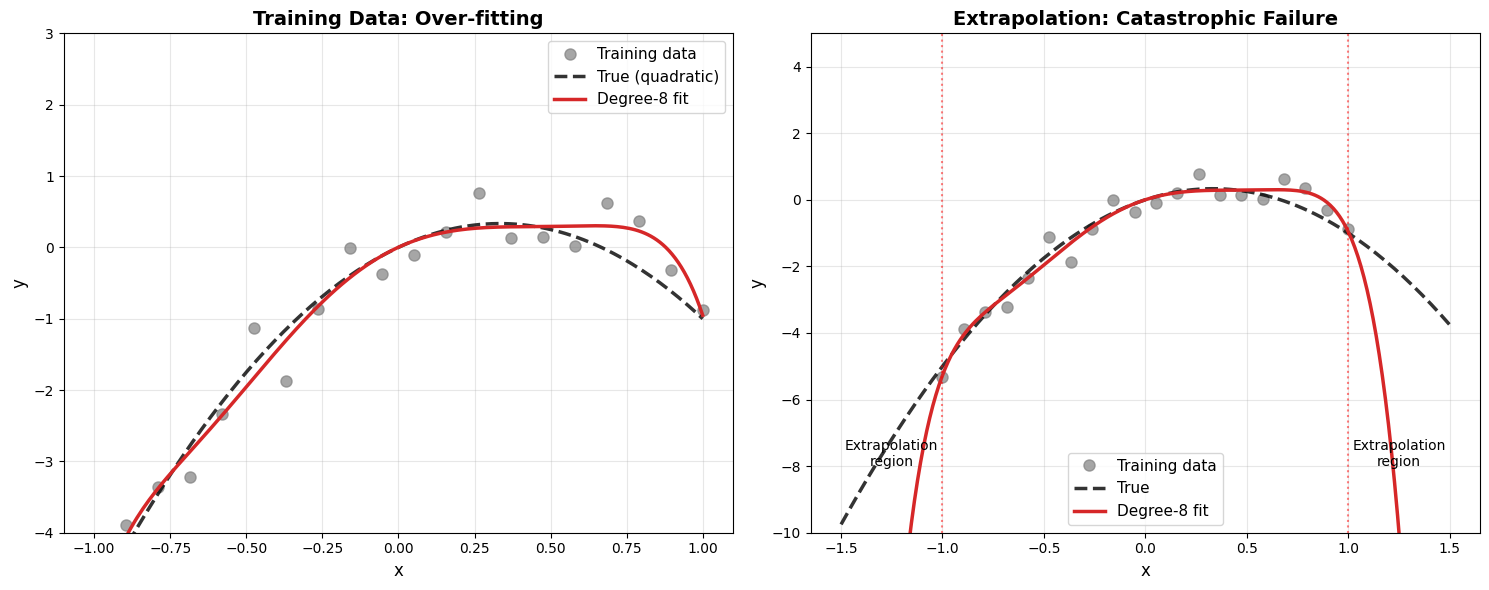


⚠️  Over-fitting Alert!
   The high-degree polynomial fits training data well but
   extrapolates poorly. Regularisation would help!


In [9]:
# Visualize fits
x_dense = np.linspace(-1, 1, 200)


def eval_poly(x, coeffs):
    y = np.zeros_like(x)
    for i, c in enumerate(coeffs):
        y += c * x**i
    return y


y_true_dense = 2 * x_dense - 3 * x_dense**2
y_unreg_dense = eval_poly(x_dense, result_unreg.x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Training data fit
ax1.plot(
    x_poly, y_poly, "o", label="Training data", alpha=0.7, markersize=8, color="gray"
)
ax1.plot(
    x_dense, y_true_dense, "k--", linewidth=2.5, label="True (quadratic)", alpha=0.8
)
ax1.plot(x_dense, y_unreg_dense, linewidth=2.5, label="Degree-8 fit", color="#d62728")
ax1.set_xlabel("x", fontsize=12)
ax1.set_ylabel("y", fontsize=12)
ax1.set_title("Training Data: Over-fitting", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-4, 3)

# Right: Extrapolation (shows over-fitting clearly)
x_extrap = np.linspace(-1.5, 1.5, 200)
y_true_extrap = 2 * x_extrap - 3 * x_extrap**2
y_unreg_extrap = eval_poly(x_extrap, result_unreg.x)

ax2.plot(
    x_poly, y_poly, "o", label="Training data", alpha=0.7, markersize=8, color="gray"
)
ax2.plot(x_extrap, y_true_extrap, "k--", linewidth=2.5, label="True", alpha=0.8)
ax2.plot(x_extrap, y_unreg_extrap, linewidth=2.5, label="Degree-8 fit", color="#d62728")
ax2.axvline(x=-1, color="red", linestyle=":", alpha=0.5)
ax2.axvline(x=1, color="red", linestyle=":", alpha=0.5)
ax2.set_xlabel("x", fontsize=12)
ax2.set_ylabel("y", fontsize=12)
ax2.set_title("Extrapolation: Catastrophic Failure", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-10, 5)
ax2.text(-1.25, -8, "Extrapolation\nregion", fontsize=10, ha="center")
ax2.text(1.25, -8, "Extrapolation\nregion", fontsize=10, ha="center")

plt.tight_layout()
plt.show()

print("\n⚠️  Over-fitting Alert!")
print("   The high-degree polynomial fits training data well but")
print("   extrapolates poorly. Regularisation would help!")

## Multi-Objective Cost Functions

Sometimes we want to balance **multiple objectives** simultaneously:

$$\text{Cost} = w_1 \cdot \text{Fit Quality} + w_2 \cdot \text{Smoothness} + w_3 \cdot \text{Physical Constraints}$$

In [10]:
# Example: Fit with smoothness penalty
class MultiObjectiveCost:
    """Combined data fit + smoothness penalty."""

    def __init__(self, weight_fit=1.0, weight_smooth=0.1):
        self.weight_fit = weight_fit
        self.weight_smooth = weight_smooth

    def __call__(self, predicted, observed):
        # Data fit term (SSE)
        fit_cost = np.sum((observed - predicted) ** 2)

        # Smoothness term (penalise large second derivatives)
        second_deriv = np.diff(predicted, n=2)
        smooth_cost = np.sum(second_deriv**2)

        return self.weight_fit * fit_cost + self.weight_smooth * smooth_cost


# Fit with different smoothness weights
weights_smooth = [0.0, 0.1, 1.0, 10.0]
results_multi = {}


# Cost wrapper
def wrapper(x, y_poly, cost_func):
    return cost_func(polynomial_model(x), y_poly)


for w_smooth in weights_smooth:
    # Construct custom cost
    multi_cost = MultiObjectiveCost(weight_fit=1.0, weight_smooth=w_smooth)
    result = chron.ScalarBuilder().with_objective(
        partial(wrapper, y_poly=y_poly, cost_func=multi_cost)
    )

    for i in range(degree + 1):
        result = result.with_parameter(f"c{i}", initial_params[i])

    result = (
        result.with_optimiser(chron.NelderMead().with_max_iter(2000)).build().optimise()
    )

    results_multi[w_smooth] = result
    print(
        f"Smoothness weight={w_smooth:5.1f}: SSE={np.sum((eval_poly(x_poly, result.x) - y_poly) ** 2):.3f}"
    )

Smoothness weight=  0.0: SSE=1.807
Smoothness weight=  0.1: SSE=1.816
Smoothness weight=  1.0: SSE=1.976
Smoothness weight= 10.0: SSE=2.267


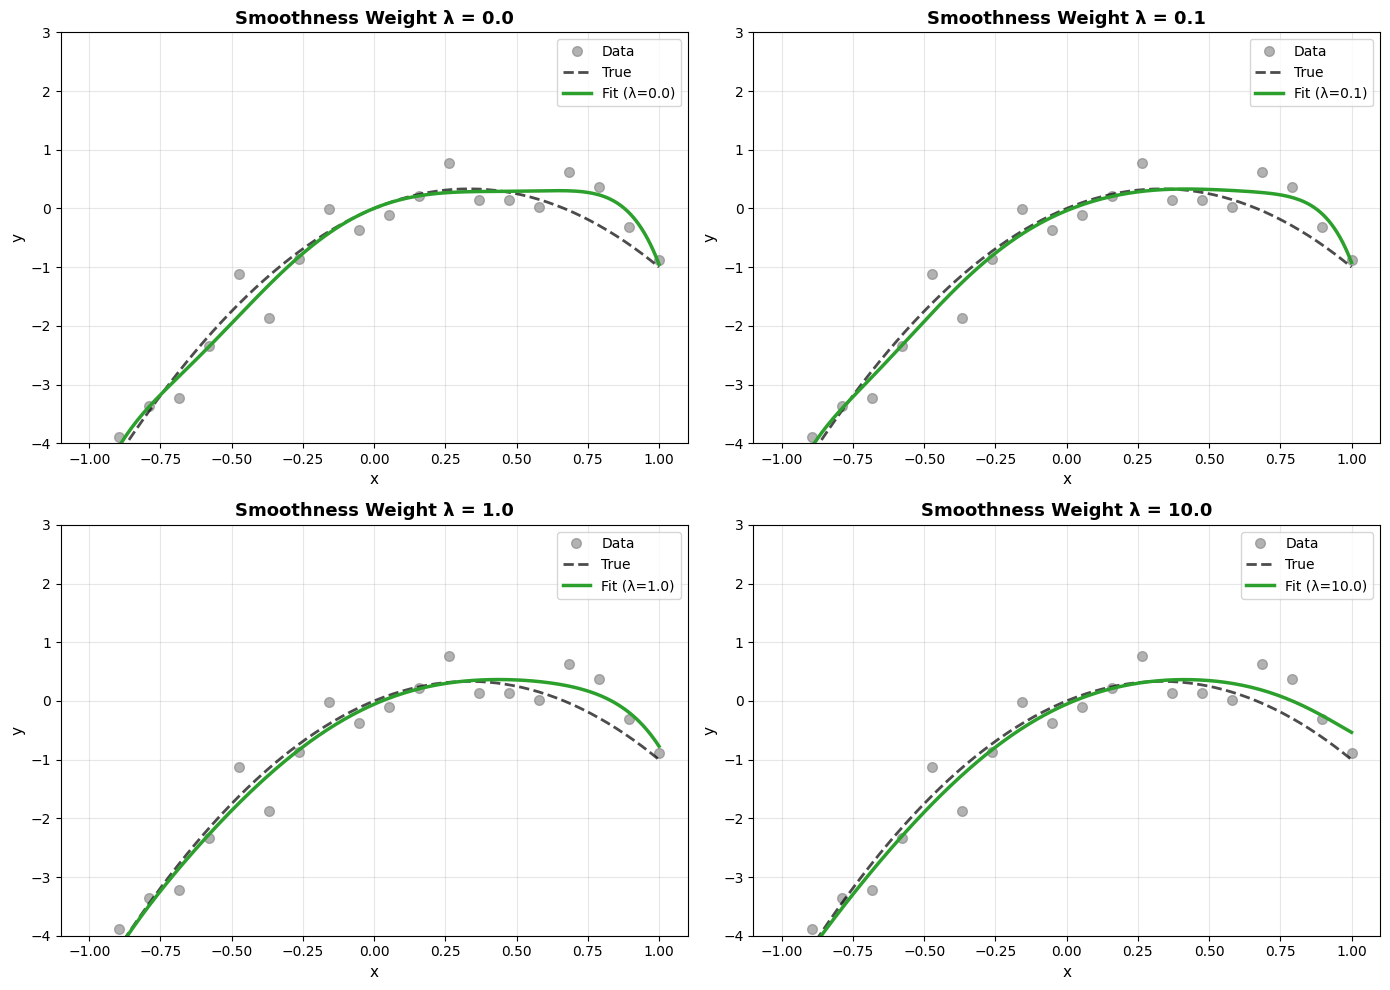


💡 Smoothness Penalty Effect:
   λ=0.0:  No penalty → over-fitting
   λ=0.1:  Slight smoothing
   λ=1.0:  Balanced fit
   λ=10.0: Too smooth → under-fitting


In [11]:
# Visualize effect of smoothness weight
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (w_smooth, result) in enumerate(results_multi.items()):
    ax = axes[idx]

    y_fit = eval_poly(x_dense, result.x)

    ax.plot(x_poly, y_poly, "o", label="Data", alpha=0.6, markersize=7, color="gray")
    ax.plot(x_dense, y_true_dense, "k--", linewidth=2, label="True", alpha=0.7)
    ax.plot(x_dense, y_fit, linewidth=2.5, label=f"Fit (λ={w_smooth})", color="#2ca02c")

    ax.set_xlabel("x", fontsize=11)
    ax.set_ylabel("y", fontsize=11)
    ax.set_title(f"Smoothness Weight λ = {w_smooth}", fontsize=13, fontweight="bold")
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-4, 3)

plt.tight_layout()
plt.show()

print("\n💡 Smoothness Penalty Effect:")
print("   λ=0.0:  No penalty → over-fitting")
print("   λ=0.1:  Slight smoothing")
print("   λ=1.0:  Balanced fit")
print("   λ=10.0: Too smooth → under-fitting")

## Physical Constraints as Cost Penalties

In scientific applications, we often have **physical constraints**:
- Parameters must be positive (e.g., rate constants)
- Conservation laws (e.g., mass balance)
- Monotonicity requirements

These can be enforced via penalty terms:

In [12]:
class ConstrainedCost:
    """Cost with soft constraints via penalties."""

    def __init__(self, penalty_weight=1000.0):
        self.penalty_weight = penalty_weight

    def __call__(self, predicted, observed, params=None):
        # Data fit term
        sse = np.sum((observed - predicted) ** 2)

        # Example constraint: parameters should sum to a target value
        if params is not None:
            # Soft constraint: sum(params) ≈ 0
            constraint_violation = (np.sum(params) - 0.0) ** 2

            # Positivity constraint: penalise negative parameters
            negative_penalty = np.sum(np.minimum(0, params) ** 2)

            penalty = self.penalty_weight * (constraint_violation + negative_penalty)
            return sse + penalty

        return sse


print("Example constraint penalties:")
print("  • Sum constraint: forces Σθᵢ ≈ target")
print("  • Positivity: penalises θᵢ < 0")
print("  • Bounds: penalises θᵢ outside [a, b]")
print("  • Monotonicity: penalises θᵢ₊₁ < θᵢ")
print("\n💡 Tip: Start with large penalty weights, then tune.")

Example constraint penalties:
  • Sum constraint: forces Σθᵢ ≈ target
  • Positivity: penalises θᵢ < 0
  • Bounds: penalises θᵢ outside [a, b]
  • Monotonicity: penalises θᵢ₊₁ < θᵢ

💡 Tip: Start with large penalty weights, then tune.


## Best Practices

### Choosing a Cost Function

1. **Default (SSE)**: Good starting point for most problems
2. **RMSE**: When comparing across datasets with different sizes
3. **GaussianNLL**: For Bayesian inference and uncertainty quantification
4. **Weighted**: When measurement errors vary (heteroscedastic data)
5. **Custom**: For domain-specific requirements

### Regularisation Guidelines

- **When to use**: High-dimensional problems, limited data, polynomial fitting
- **L2 (Ridge)**: Shrinks all coefficients smoothly
- **L1 (Lasso)**: Promotes sparsity (some coefficients → 0)
- **Tuning λ**: Cross-validation or information criteria (AIC, BIC)

### Multi-Objective Balancing

- **Start simple**: Fit data first, add penalties incrementally
- **Scale matters**: Normalise objectives to similar magnitudes
- **Weight tuning**: Use logarithmic search (0.001, 0.01, 0.1, 1, 10, ...)
- **Validation**: Check if constraints are actually satisfied

## Summary: Cost Function Design Pattern

```python
class CustomCost:
    def __init__(self, **hyperparameters):
        # Store configuration
        pass
    
    def __call__(self, predicted, observed, params=None):
        # 1. Data fidelity term
        fit_cost = compute_fit(predicted, observed)
        
        # 2. Regularisation term (optional)
        reg_cost = compute_regularisation(params)
        
        # 3. Physical constraints (optional)
        constraint_cost = compute_penalties(params)
        
        # 4. Combine with weights
        return w1*fit_cost + w2*reg_cost + w3*constraint_cost
```

## Key Takeaways

1. **Built-in metrics** (SSE, RMSE, GaussianNLL) cover most use cases
2. **Weighted fitting** essential for heteroscedastic data (varying errors)
3. **Regularisation** prevents over-fitting in high-dimensional problems
4. **Multi-objective costs** balance competing goals (fit vs smoothness)
5. **Constraint penalties** enforce physical requirements
6. **Custom costs** are easy to implement via `__call__` interface
7. **Scale and normalisation** critical for multi-term objectives

## Next Steps

- [Guide: Cost Metrics](../../guides/cost-metrics.md) - Detailed metric selection
- [Tutorial 3: Parameter Uncertainty](03_parameter_uncertainty.ipynb) - Bayesian inference with GaussianNLL
- [API Reference: Cost Metrics](../../api-reference/python/cost-metrics.md) - Complete API

## Exercises

1. **Implement L1 Regularisation**: Create a `LassoSSE` class and compare with L2

2. **Cross-Validation**: Implement k-fold cross-validation to tune regularisation strength

3. **Robust Fitting**: Implement Huber loss (robust to outliers):
   $$L_\delta(r) = \begin{cases} \frac{1}{2}r^2 & \text{for } |r| \leq \delta \\ \delta(|r| - \frac{1}{2}\delta) & \text{otherwise} \end{cases}$$

4. **Time-Series Smoothness**: Add a penalty on parameter changes over time for dynamic fitting

5. **Information Criteria**: Compute AIC and BIC for model selection:
   - AIC = $2k - 2\ln(\mathcal{L})$
   - BIC = $\ln(n)k - 2\ln(\mathcal{L})$